In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from ipywidgets import interact, SelectionSlider, IntSlider

In [2]:
import metadata_util
spec_names = metadata_util.read_spec_names()
phy_names = metadata_util.get_phy_names()
jval_names = metadata_util.read_jval_names()

In [3]:
import sys
sys.path.append("../../GEOSChem/KPP4GC/GC_12_Standard/") # dirty fix to allow importing
import kpp4py

In [4]:
ds = xr.open_dataset('./KPP_fields_100.nc')

ds_sub = ds.isel(lev=slice(0, 20)).stack(sample=('lev', 'lat', 'lon')).transpose()
ds_sub

<xarray.Dataset>
Dimensions:   (nphotol: 130, nphy: 4, nreact: 725, nspec: 240, sample: 66240)
Coordinates:
  * sample    (sample) MultiIndex
  - lev       (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - lat       (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - lon       (sample) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Dimensions without coordinates: nphotol, nphy, nreact, nspec
Data variables:
    C_before  (sample, nspec) float64 5.722e+03 1.662e+06 1.446e+05 ...
    C_after   (sample, nspec) float64 5.722e+03 1.662e+06 1.446e+05 ...
    PHOTOL    (sample, nphotol) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    PHY       (sample, nphy) float64 203.3 703.9 2.508e+19 1.243e+14 203.3 ...
    RCONST    (sample, nreact) float64 1.872e-15 1.668e-14 8.976e-16 ...

In [5]:
random_idx = np.random.randint(ds_sub.dims['sample'])
ds_one = ds_sub.isel(sample=random_idx)
ds_one 

<xarray.Dataset>
Dimensions:   (nphotol: 130, nphy: 4, nreact: 725, nspec: 240)
Coordinates:
    sample    object (8, 9, 61)
Dimensions without coordinates: nphotol, nphy, nreact, nspec
Data variables:
    C_before  (nspec) float64 10.14 1.021e+06 4.25e+04 1.969e+05 0.0 ...
    C_after   (nspec) float64 -0.003085 9.154e+05 2.831e+04 1.969e+05 ...
    PHOTOL    (nphotol) float64 2.785e-28 0.0001425 1.795e-06 0.0 0.0 ...
    PHY       (nphy) float64 271.7 876.6 2.327e+19 1.352e+17
    RCONST    (nreact) float64 1.2e-14 5.343e-14 1.647e-15 1.454e-17 ...

In [6]:
ref_c_before = ds_one['C_before'].values
ref_phy = ds_one['PHY'].values
ref_photol = ds_one['PHOTOL'].values

ref_c_before.shape, ref_phy.shape, ref_photol.shape

((240,), (4,), (130,))

In [7]:
ref_features = np.r_[ref_c_before, ref_phy, ref_photol]
ref_features.shape

(374,)

In [8]:
ref_c_after = kpp4py.onestep(ref_c_before, ref_phy, ref_photol).ravel()
ref_c_after.shape

(240,)

In [9]:
n_c = ref_c_before.shape[0]
n_phy = ref_phy.shape[0]
n_jv = ref_photol.shape[0]

n_features = n_c + n_phy + n_jv
n_features

374

In [10]:
dr = 0.1 # perturb ratio

perturb_features = np.empty([n_features, n_features])

perturb_features[:] = ref_features
for i in range(n_features):
    perturb_features[i, i] *= (1.0+dr)
    
perturb_c_before = perturb_features[:,0:n_c]
perturb_phy = perturb_features[:,n_c:n_c+n_phy]
perturb_jvals = perturb_features[:,n_c+n_phy:]

In [11]:
%%time
perturb_c_after = kpp4py.onestep(perturb_c_before.T, 
                                 perturb_phy.T, 
                                 perturb_jvals.T).T
print(perturb_c_after.shape)

(374, 240)
CPU times: user 268 ms, sys: 2.42 ms, total: 271 ms
Wall time: 270 ms


In [12]:
ref_c_after.shape

(240,)

In [13]:
ref_c_before.shape

(240,)

In [14]:
A = (perturb_c_after/ref_c_after - 1)/dr # sensitivity matrix (relative change)
A.shape

/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(374, 240)

Text(0.5,1,'sensitivity matrix')

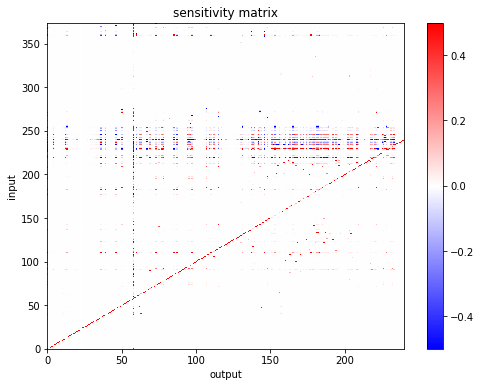

In [15]:
plt.figure(figsize=[8, 6])
plt.pcolormesh(A, cmap='bwr', vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.ylabel('input')
plt.xlabel('output')
plt.title('sensitivity matrix')

In [16]:
feature_importance = (np.abs(A) > 0.5).sum(axis=1)
feature_importance

/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([ 2,  2,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  2,  1,  2,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  2,  1,  1,  0,
        1,  0,  1,  1,  1,  1,  2,  1,  2,  1,  0,  1,  1,  1,  1,  2,  1,
        1,  2,  1,  1,  1,  2,  2,  4,  1,  0,  1,  0,  1,  1,  1,  2,  2,
        1,  3,  1,  1,  2,  1,  4,  0, 15,  1,  0,  1,  1,  1,  1,  2,  1,
        1,  1,  1,  4,  2,  1,  3,  2,  1,  1,  1,  1,  0,  2,  4,  1,  1,
        2,  1,  0,  0,  1,  2,  0,  2,  0,  1,  1,  1,  0,  1,  5,  0,  0,
        0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,
        0,  0,  0,  9,  0,  1,  0,  1,  1,  0,  1,  0,  0,  6,  0,  3,  0,
        0,  0,  0,  1,  1,  0,  1,  0,  3,  0,  4,  3,  1,  2,  2,  1,  0,
        0,  0,  2,  1,  1,  2,  3,  3,  2,  1,  5,  2,  3,  1,  1,  8,  1,
        1,  1,  1,  1,  0

In [17]:
df_importance = pd.Series(feature_importance, 
                          index = spec_names+phy_names+jval_names)

In [18]:
df_importance.nlargest(20)

TEMP           82
O3             62
NO2            16
H2O            16
HOI            15
116/HOI/HOI    14
ISOP            9
3/O3/O3(1D)     9
CO              8
12/NO3/NO3      8
O2              7
NUMDEN          7
IO              6
117/IO/IO       6
CH4             5
MACR            5
N2              5
118/OIO/OIO     5
CH3Cl           4
C3H8            4
dtype: int64

In [19]:
input_dependence = (np.abs(A) > 0.5).sum(axis=0)
input_dependence

/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([21,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1,  1,  5,  5,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 10,  1,  1,  4,  1,  1,  1,  1,  1,  1,  7,  2,  2,  1,  6,
        1,  1,  1,  1,  1,  1,  1, 90,  1,  8,  1,  3,  3,  1,  1,  1,  6,
        1,  2,  1,  2,  1,  5,  1,  2,  1,  3,  5,  1,  1,  1,  1,  1,  1,
        7,  1,  5,  1,  1,  1,  1,  1,  1,  2,  2,  2,  5,  2,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  1,  3,  1,  1,  3,  1,  1,  5,  1,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  2,
        1,  5,  3,  3,  2,  1,  4,  2,  2,  1,  9,  1,  3,  1,  1,  3,  4,
        5,  4,  4,  3,  1,  1,  4,  2,  1,  4,  3,  1,  3,  3,  2,  4,  1,
        3,  4,  3,  1,  2,  1,  2,  5,  2,  3,  2,  3,  3,  3,  3,  1,  4,
        3,  1,  2,  1,  1,  2,  2,  2,  1,  4,  1,  1,  1,  1,  1,  3,  1,
        2,  2,  1,  1,  5,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,
        3,  4,  1,  1,  3

In [20]:
df_dependence = pd.Series(input_dependence, index = spec_names)

In [21]:
df_dependence.nlargest(40)  # this depends greatly on particular sample!

IBr         90
CH2I2       21
I2O4        10
I2           9
INO          8
I2O3         7
IONO         7
BrNO2        6
N            6
CO2          5
LISOPOH      5
LISOPNO3     5
ICl          5
Cl2O2        5
OIO          5
OClO         5
Br2          5
IONO2        5
ISNOOB       5
I            5
MRO2         5
O            5
I2O2         4
N2O5         4
H            4
MVKOO        4
GAOO         4
CH3CHOO      4
MGLYOO       4
MGLOO        4
ISOPNDO2     4
MACROO       4
ISOPNBO2     4
CH2OO        4
NO           4
NO3          4
OH           4
TRO2         3
BRO2         3
MPN          3
dtype: int64

In [22]:
df_A = pd.DataFrame(A, columns=spec_names, index=spec_names+phy_names+jval_names)

In [24]:
df_A['CH2I2'][df_A['CH2I2'] > 1]

CH2I2      1.077096
O          1.443269
O3         1.409982
O2         1.452379
TEMP       2.159021
NUMDEN     1.295124
2/O3/O3    1.529089
Name: CH2I2, dtype: float64

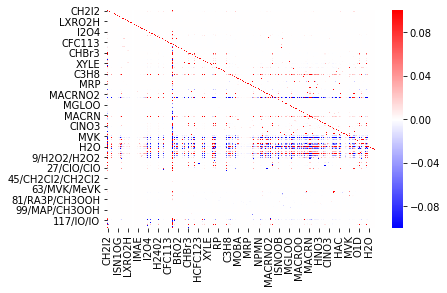

In [25]:
sns.heatmap(df_A, cmap='bwr', vmin=-0.1, vmax=0.1)